In [ ]:
import pandas as pd 
import numpy as np 
import os 
import gc 
import time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from glob import glob
sns.set()
sns.set_palette('pastel')
params = {'legend.fontsize': 10,
          'figure.figsize': (15, 5),
         'axes.labelsize': 15,
         'axes.titlesize':20,
         'xtick.labelsize':15,
         'font.size':20,
         'axes.titlesize': 20}
plt.rcParams.update(params)
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
glob('*.csv')

['order_products__prior.csv',
 'aisles.csv',
 'departments.csv',
 'orders.csv',
 'sample_submission.csv',
 'order_products__train.csv',
 'products.csv']

## 静态属性

In [4]:
ais = pd.read_csv('aisles.csv')
depart = pd.read_csv('departments.csv')
prod = pd.read_csv('products.csv')
prod_all = prod.merge(ais, on = 'aisle_id', how = 'left')
prod_all = prod_all.merge(depart, on = 'department_id', how = 'left')
del ais; del depart; del prod; 
prod_all.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,2,All-Seasons Salt,104,13,spices seasonings,pantry
2,3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen
4,5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry


## sample 

In [2]:
orders = pd.read_csv('orders.csv')
orders_prior = pd.read_csv('order_products__prior.csv')
orders_train = pd.read_csv('order_products__train.csv')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [4]:
orders = pd.read_csv('orders.csv')
orders_prior = pd.read_csv('order_products__prior.csv')
orders_detail = orders_prior.merge(orders, on = 'order_id', how ='left')

## EDA: prepare for feature engineering 

### 目标解析
1. order里面存放了所有订单（prior + train +test)的 order_id, user_id, 下单的时间，和距上一次的下单的天数
2. train和test都是用户下的最后一单，prior是（train + test)用户之前的下单。train和test里面的uid都唯一

In [57]:
flag = orders['eval_set']=='test'
print 'All user_id appear only 1 time in test set ? {}'.format(
    orders.loc[flag,:].shape[0] == len(orders.loc[flag,'user_id'].unique()) )
flag = orders['eval_set']=='train'
print 'All user_id appear only 1 time in train set ? {}'.format(
    orders.loc[flag,:].shape[0] == len(orders.loc[flag,'user_id'].unique()) )

All user_id appear only 1 time in test set ? True
All user_id appear only 1 time in train set ? True


In [56]:
max_number = orders.groupby('user_id')['order_number'].agg('max').to_frame()
max_number.columns = ['max_order']
test_number = orders.loc[orders['eval_set']=='test', ['order_number', 'user_id']]
compare = test_number.merge(max_number, how = 'left', left_on = 'user_id', left_index=False,  right_index = True)
print 'Test set are the last order of user? {}'.format(all(compare['order_number'] == compare['max_order']) )
train_number = orders.loc[orders['eval_set']=='train', ['order_number', 'user_id']]
compare = train_number.merge(max_number, how = 'left', left_on = 'user_id', left_index=False,  right_index = True)
print 'Train set are the last order of user? {}'.format(all(compare['order_number'] == compare['max_order']) )
del compare

Test set are the last order of user? True
Train set are the last order of user? True


### 用户订单特征分布：训练/测试集，预测order的下述特征分布基本一致
1. order number： 需要预测的订单是用户的第几个订单（
2. weekday: train vs prior vs test： 用户星期几下单
3. hour of day: train vs prior vs test： 用户下单hour
4. days_since_prior: 用户距上一次下单的时间(可以理解为样本可预测性，离得越近历史信息越有价值越好预测)
5. 敲黑板： days_since_prior有周期性！！

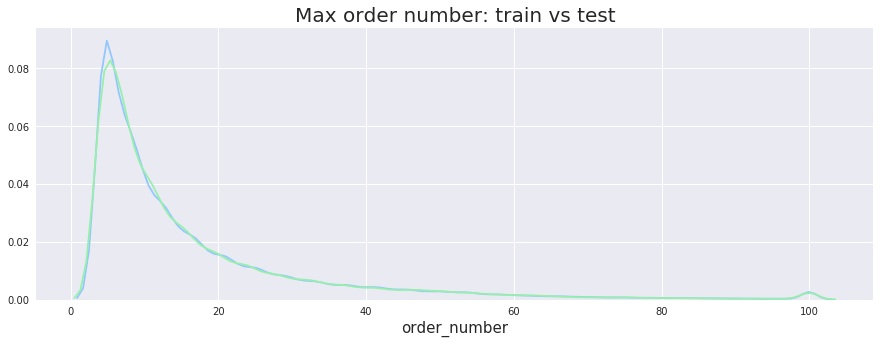

In [37]:
sns.distplot(a = orders.loc[orders['eval_set'] =='train','order_number'], hist = False)
sns.distplot(a = orders.loc[orders['eval_set'] =='test','order_number'], hist = False)
plt.title('Max order number: train vs test')
plt.show()

/home/tiger/anaconda2/envs/DS/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


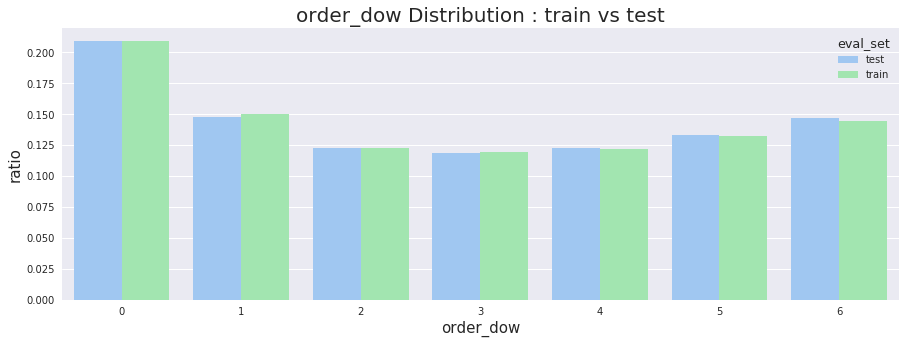

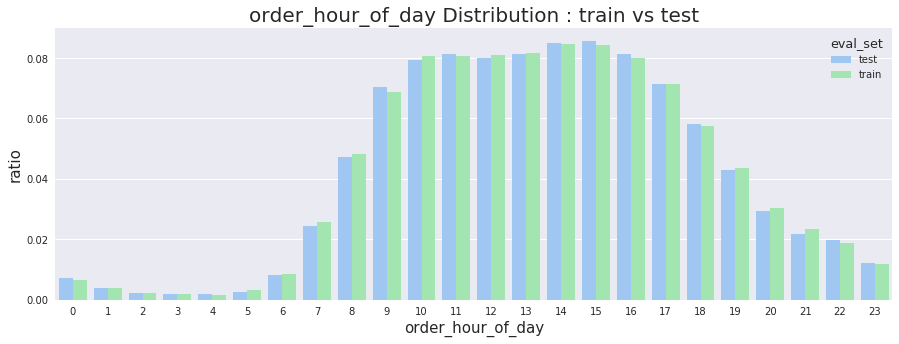

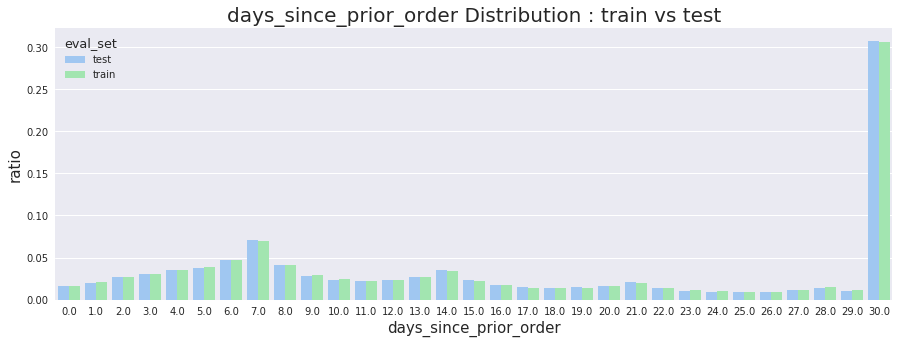

In [40]:
tag_list = ['order_dow', 'order_hour_of_day','days_since_prior_order']
for i in tag_list:
    stat = orders.groupby(['eval_set', i])['user_id'].agg({'count':'count'})
    stat = stat.loc[['test', 'train'], : ]
    stat['ratio'] = stat['count'].div(stat.groupby('eval_set')['count'].sum())
    stat.reset_index(level = [0,1], inplace=True)

    plt.figure(figsize = (15,5))
    sns.barplot(x= i , y='ratio', hue = 'eval_set', data = stat)
    plt.title('{} Distribution : train vs test'.format(i))
    plt.show()

### 产品特征分布： 取train，test里面uid的prior order的产品看它们的大分类和细分, 下述维度分布基本一致
1. departmentid
2. aisle_id 

In [8]:
train_order = orders.loc[(orders['user_id'].isin(orders.loc[orders['eval_set'] =='train', 'user_id'])) &\
                         (orders['eval_set'] =='prior'),'order_id']
orders_prior['flag'] = orders_prior['order_id'].isin(train_order)
orders_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,flag
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,True
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,True
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,True
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,True
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,True


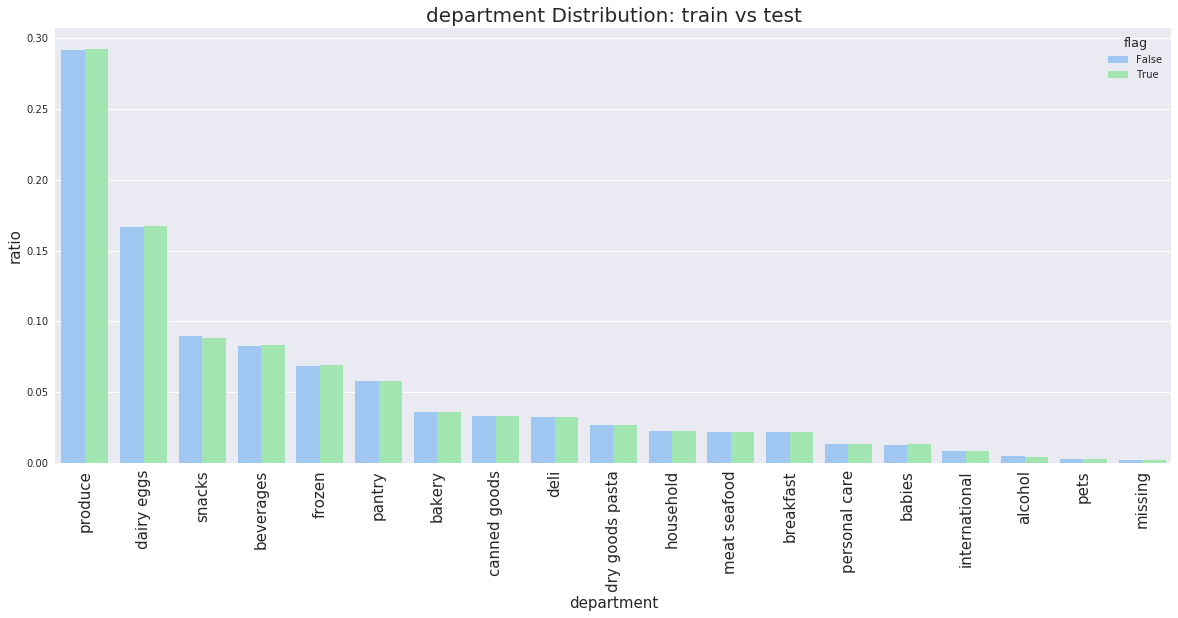

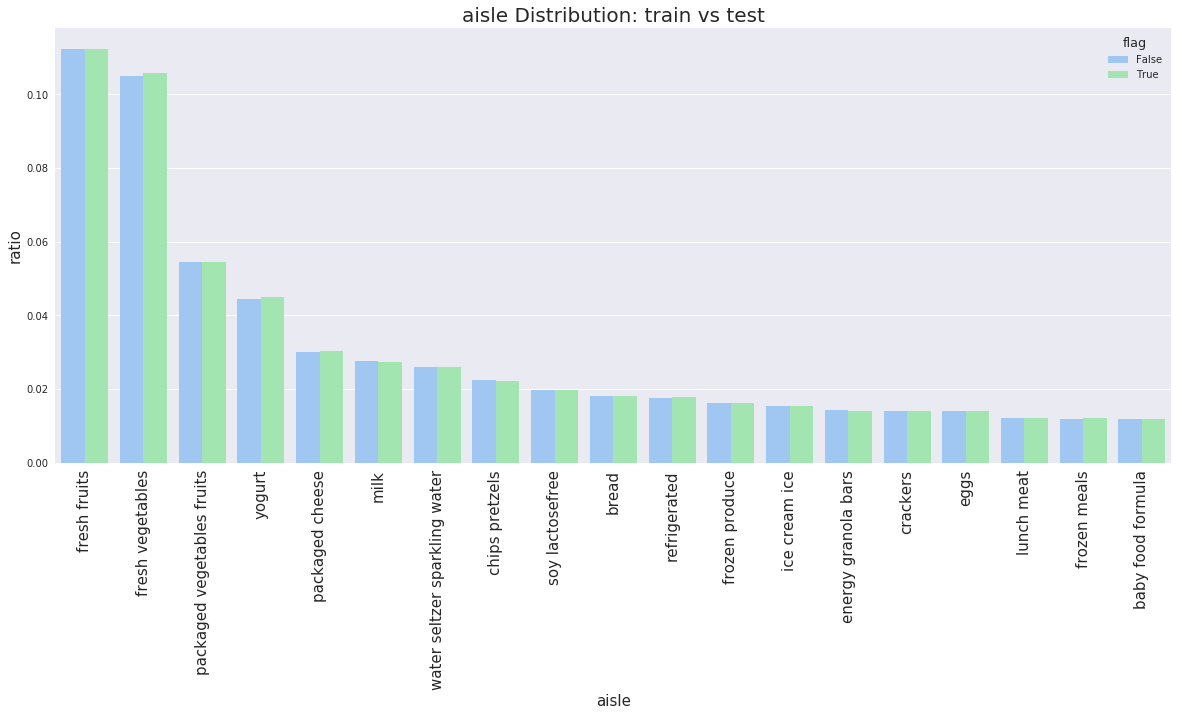

In [54]:
tag_list = ['department', 'aisle']
for i in tag_list:
    stat = orders_prior.groupby(['flag', i])['order_id'].agg({'count':'count'})
    stat['ratio'] = stat['count'].div(stat.groupby('flag')['count'].sum())
    stat.reset_index(level = [0,1], inplace =True)
    stat.sort_values(by = ['ratio','flag'], ascending= False, inplace =True)
    
    plt.figure(figsize =(20,8))
    sns.barplot(x = i, y = 'ratio', hue = 'flag',  data = stat.iloc[:38,:])
    plt.title('{} Distribution: train vs test'.format(i))
    plt.xticks(rotation = 90)
    
    plt.show()

### 所有特征对reorder的影响: 移除train，只考虑prior 
1. 订购次数越多的人越reorder概率越高 - Instcart 成功让人们养成了习惯
2. 上午reorder的概率显著 > 下午,晚上 > 凌晨
3. 距上次订购越远reorder概率下降，人们大概早忘了上次订了啥。而且在7，14等周期点有上升
4. add_to_cart_order: reorder的产品一般最先被加入购物车
5. reorder概率最高的集中在吃喝，且相似品种reorder概率相似（会不会有product pair?5

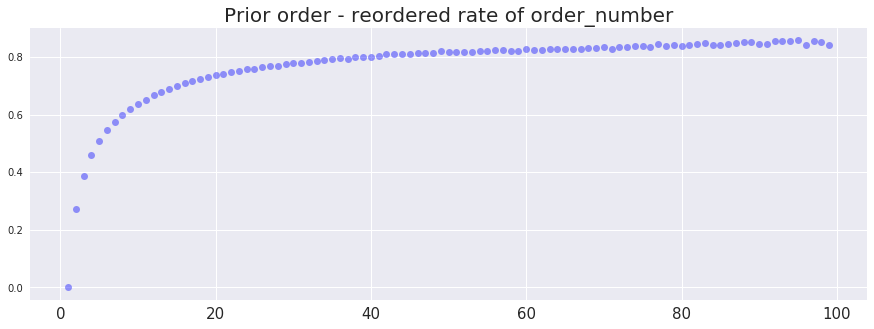

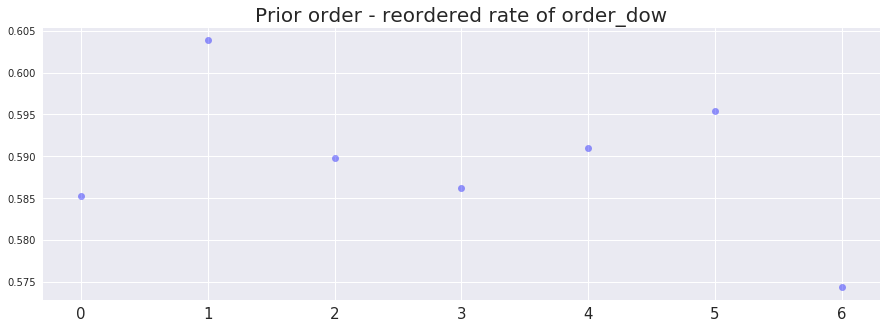

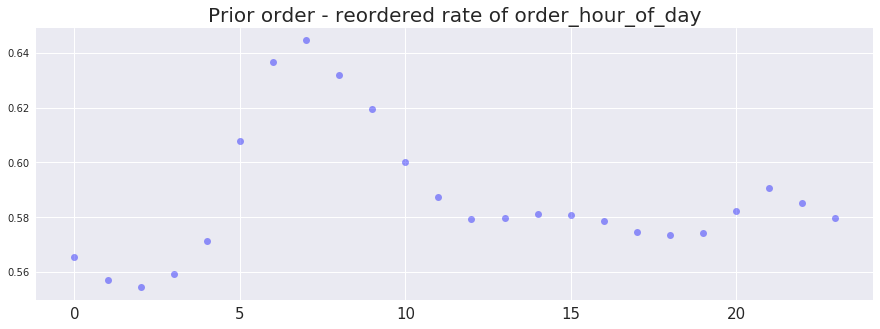

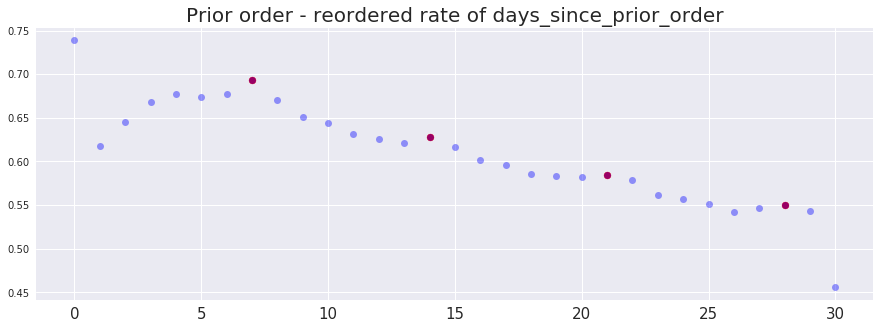

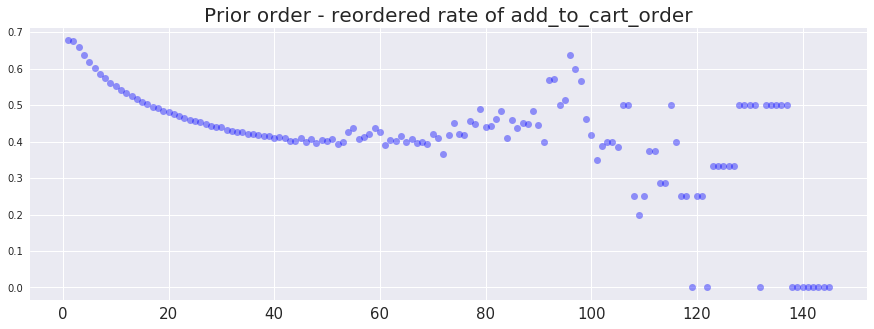

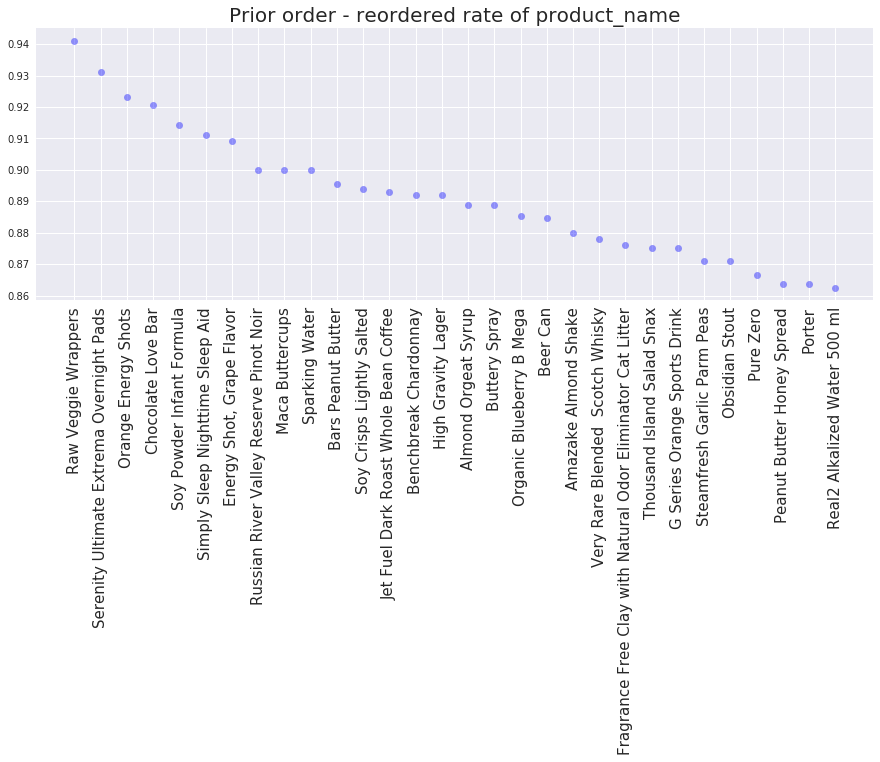

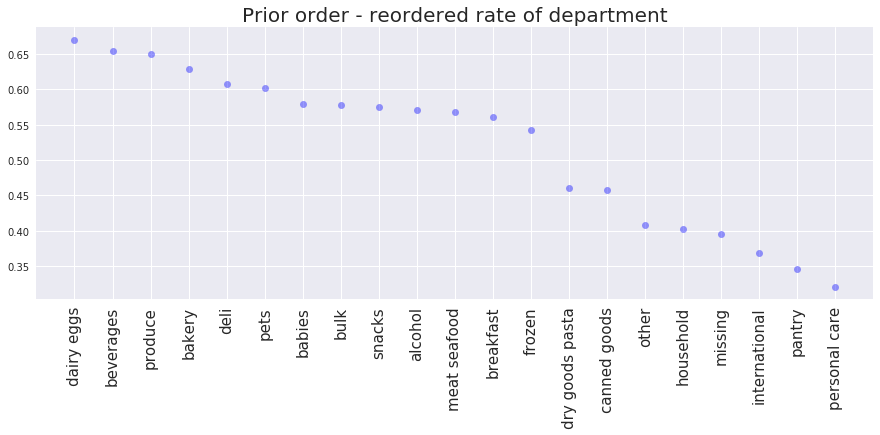

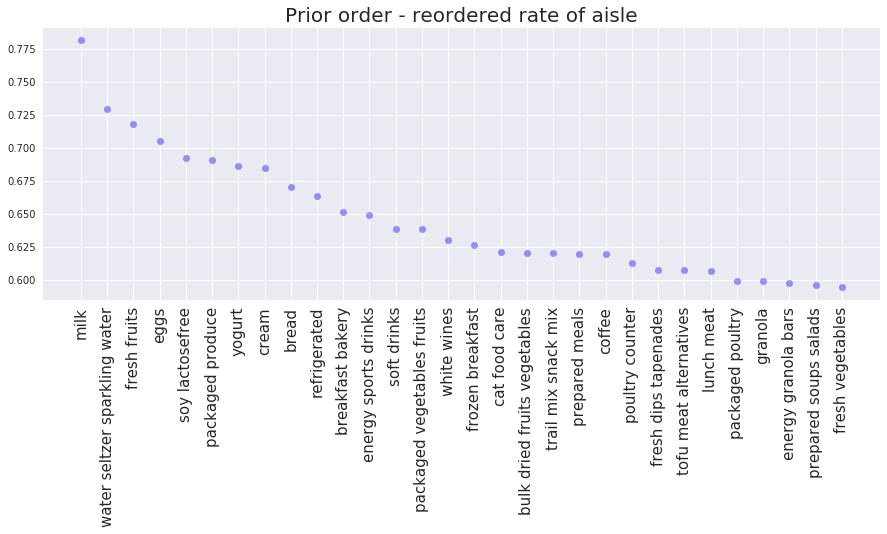

In [83]:

tag_list = ['order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
            'add_to_cart_order', 'product_name', 'department','aisle']

for i in tag_list:
    stat = orders_detail.\
            groupby(i)['reordered'].\
            agg({'ratio': lambda x:  float(sum(x))/len(x)})
    stat.reset_index(inplace = True)

    stat.sort_values(by = 'ratio', ascending = False, inplace = True)
    
    if i in ['product_name','department', 'aisle']:
        ## cut too many department and aisle 
        stat = stat.iloc[:30,:]
    
    plt.plot(stat[i], stat['ratio'], 'bo', alpha= 0.4)
    
    if i =='days_since_prior_order':
        ## show weekday pattern  
        plt.scatter([7,14,21,28], stat.loc[stat[i].isin([7,14,21,28]),'ratio'], color="red")
        
    plt.title('Prior order - reordered rate of {}'.format(i))
    
    if i in ['product_name', 'department','aisle']:
        plt.xticks(rotation= 90)
    plt.show()

## Feature Engineering 

- 核心特征
    - uid + pid + T(last1, last3,...): order_t, reorder_rate_t, avg_add_to_cart_order, time_since_last 
- 放松pid相关的限定
    - uid + pid -> aisle: order_rate(by order), reorder_rate(by product)
    - uid + pid -> department: 同上
    - uid only: reodered rate, avg number of item( q1, q3, med)
- 放松uid相关的限定
    - pid: reordered rate 
    - pid + 

- uid相关stats 
    -  avg_days_gap,
    -  
    - order_number
    - 
- pid属性Encodding: reordered rate
    - aisle 
    - department
    
- order属性Encoding: reordered rate
    - order_dow
    - order_hour_of_day
    - days_since_prior
    - order_number

In [ ]:
## get data for feature engineering 
orders = pd.read_csv('orders.csv')
orders_prior = pd.read_csv('order_products__prior.csv')
orders_detail = orders_prior.merge(orders, on = 'order_id', how ='left')
gc.collect()
orders_detail.rename(columns = {'days_since_prior_order': 'time_since_last',
                               'order_dow':'weekday', 
                                'order_hour_of_day':'hour_of_day'}, inplace = True)
orders_detail.to_csv('orders_detail.csv', index = False )
del orders_prior

In [12]:
# gather all info for train
df = orders_detail.loc[:,['product_id', 'user_id', 'aisle_id', 'department_id']].drop_duplicates()
df_train = df.merge(orders.loc[orders['eval_set']=='train',:], on = 'user_id', how = 'inner')

del orders
def df
gc.collect()

# add target 
orders_train = pd.read_csv('order_products__train.csv')
df_train = df_train.merge(orders_train, on= ['order_id', 'product_id'], how = 'left')
df_train.fillna(0, inplace = True)

del orders_train
gc.collect()

# rename column 
df_train.rename(columns = {'days_since_prior_order': 'time_since_last',
                           'order_dow':'weekday', 
                            'order_hour_of_day':'hour_of_day'}, inplace = True)
df_train.to_csv('df_train.csv', index = False)

In [42]:
## use the initial to name the feature
feature_item = ['user_id', 'product_id', 'department_id', 'aisle_id']
feature_attr = ['weekday', 'hour_of_day', 'time_since_last']

## uid + pid/department/aisle
feature_pair_basic = zip(feature_item[0:1] *3, feature_item[1:])
## (uid, pid ,department, aisle) + (order_dow, order_hour, time_since_lst)
feature_pair_attr = zip( feature_item * 3 , feature_attr * 4)
print feature_pair_basic + feature_pair_attr

[('user_id', 'product_id'), ('user_id', 'department_id'), ('user_id', 'aisle_id'), ('user_id', 'weekday'), ('product_id', 'hour_of_day'), ('department_id', 'time_since_last'), ('aisle_id', 'weekday'), ('user_id', 'hour_of_day'), ('product_id', 'time_since_last'), ('department_id', 'weekday'), ('aisle_id', 'hour_of_day'), ('user_id', 'time_since_last'), ('product_id', 'weekday'), ('department_id', 'hour_of_day'), ('aisle_id', 'time_since_last')]


In [41]:
orders_detail = pd.read_csv('orders_detail.csv')
df_train = pd.read_csv('df_train.csv')

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,weekday,hour_of_day,time_since_last
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


In [ ]:
feature_collect = dict()
for i,j in (feature_pair_basic + feature_pair_attr):
    ## number of orders and reorder rate
    print 'calculate reorder feature :{} + {} '.format(i, j )
    f1 = orders_detail. \
        groupby([i,j])['reordered']. \
        agg({'order_cnt_{}'.format(i[0] + j[0]): lambda x: len(x)})
    f2 = orders_detail. \
        groupby([i,j])['reordered']. \
        agg({'reorder_pct_{}'.format(i[0] + j[0]): lambda x: float(sum(x)) / len(x)})
    ## whether the product are the first to be added
    f3 = orders_detail.\
        groupby([i,j])['add_to_cart_order'].\
        agg({'avg_add_order_{}'.format(i[0] + j[0]): 'mean'})
    feature_collect[f1.columns[0]] = f1
    feature_collect[f2.columns[0]] = f2
    feature_collect[f3.columns[0]] = f3

In [ ]:
ColMap = {'time_since_last': 'med_day_gap_{}',
          'hour_of_day': 'med_hour_{}',
          'order_dow': 'med_dow_{}'}

for i,j in (feature_pair_basic + feature_pair_attr):
    ## uid + pid -> order time. to compare with the final order
    print 'calculate time feature: {} + {}'.format(i, j)
    for col in ColMap.keys():
        if col == j:
            next;
        f = orders_detail.\
            groupby([i,j])[col].\
            agg({ColMap[col].format(i[0] + j[0]): 'median'})

        feature_collect[f.columns[0]] = f

calculate time feature: user_id + product_id


In [ ]:
## single feature : fill up for the product/department/f
for i in feature_item + feature_attr:
    print 'reorder feature for {}'.format(i)
    f = orders_detail.\
        groupby(i)['reordered']. \
        agg({'order_cnt_{}'.format(i[0]): lambda x: len(x),
             'reorder_pct_{}'.format(i[0]): lambda x: float(sum(x)) / len(x)})
    featurec_collect[f.columns[0]] = f

In [ ]:
class CONST:
    ## FEATURE SELECTION
    FEATURE_ABANDON = []
    ## use target encoding, insteaad of id itself
    FEATURE_TARGET = ['product_id', 'user_id', 'order_id', 'eval_set', 'department_id', 'aisle_id'] 
    TARGET = ''

    ## MODEL TRAINING PARAMETER
    APPAGE_SPLIT_THRESHOLD = 30
    VERBOSE = 1
    PARAMS = {'objective': 'binary',
            'metric':'auc,cross_entropy',
            'learning_rate': 0.01,
            'bagging_fraction' : 0.9,
            'feature_fraction': 0.9,
            'max_depth': 5}
    NUM_ITER = 2000
    EARLY_STOPPING = 30
    TEST_NEED = True
    NTHREAD = -1


In [ ]:
class ActiveScoreModel(object):
    def __init__(self, model_path):
        ## main Input to train model
        self.df = None
        self.model_path = model_path
        
        ## model parameter
        self.target = CONST.TARGET
        self.params = CONST.PARAMS
        self.test_need = CONST.TEST_NEED
        self.num_iter = CONST.NUM_ITER
        self.early_stopping = CONST.EARLY_STOPPING

        ## Model Related
        self.df_split = None
        self.features = None
        self.model = None
        self.result = None

        # get features
        self.feature_selection()

    def strat_split(self):
        df = self.df
        if self.test_need:
            ## evaluate test for overfitting check
            train_x, oob_x, train_y, oob_y = train_test_split(df, df.loc[:, self.target],
                                                              test_size=0.4,
                                                              random_state=CONST.SEED)
            test_x, valid_x, test_y, valid_y = train_test_split(oob_x, oob_y,
                                                                test_size=0.5,
                                                                random_state=CONST.SEED,
                                                                stratify=oob_y)
            print'Sample Split train shape ={}, valid shape = {}, test shape = {}'.format(train_x.shape,
                                                                                          valid_x.shape,
                                                                                          test_x.shape)
            self.df_split = {'train_x': train_x,
                            'train_y': train_y,
                            'valid_x': valid_x,
                            'valid_y': valid_y,
                            'test_x': test_x,
                            'test_y': test_y}

        else:
            ## use more data to train
            train_x, valid_x, train_y, valid_y = train_test_split(df, df.loc[:, self.target],
                                                                  test_size=0.2,
                                                                  random_state=CONST.SEED)
            print 'Sample Split train shape ={}, valid shape = {}'.format(train_x.shape,
                                                                         valid_x.shape)
            self.df_split =  {'train_x': train_x,
                              'train_y': train_y,
                              'valid_x': valid_x,
                               'valid_y': valid_y}


    def model_run(self, stage_predict):
        print 'Start Model Training...'
        self.model, self.result = self.train_process(train_x = self.df_split['train_x'].loc[:, self.features],
                                                     train_y = self.df_split['train_y'],
                                                     params = self.params,
                                                     n_estimators = self.num_iter,
                                                     early_stopping = self.early_stopping,
                                                     valid_x = self.df_split['valid_x'].loc[:, self.features],
                                                     valid_y = self.df_split['valid_y'],
                                                     test_x = self.df_split.\
                                                             get('test_x',
                                                             pd.DataFrame(None,columns = self.features)).loc[:, self.features],
                                                     stage_predict = stage_predict)
        print 'Model Training Finished'

    @staticmethod
    def train_process(train_x, train_y, params,
                      n_estimators, early_stopping,
                      valid_x, valid_y, test_x=None,
                      stage_predict=False):

        params['nthread'] = CONST.NTHREAD
        pred_valid = None
        pred_train = None
        pred_test = None

        lgbtrain = lgb.Dataset(train_x, label=train_y)
        lgbvalid = lgb.Dataset(valid_x, label=valid_y)

        if stage_predict:
            stage_predict = {}
            model = lgb.train(params, lgbtrain, num_boost_round=n_estimators,
                              valid_sets=[lgbvalid, lgbtrain],
                              valid_names=['valid', 'train'],
                              early_stopping_rounds=early_stopping, verbose_eval=CONST.VERBOSE,
                              evals_result=stage_predict)
        else:
            model = lgb.train(params, lgbtrain, num_boost_round=n_estimators,
                              valid_sets=lgbvalid,
                              early_stopping_rounds=early_stopping, verbose_eval=CONST.VERBOSE)

        if test_x is not None:
            pred_test = model.predict(test_x, num_iteration=model.best_iteration)

        pred_train = model.predict(train_x, num_iteration=model.best_iteration)
        pred_valid = model.predict(valid_x, num_iteration=model.best_iteration)

        return model, {'pred_train': pred_train,
                       'pred_valid': pred_valid,
                       'pred_test': pred_test}

    def model_eval(self):
        """
        Compare valid & test performance to check overfitting
        save detailed test performance to further compare with prediction
        save model feature importance and parameters to monitor feature shift
        """
        valid_eval = BinaryMetric(pred=self.result['pred_valid'], target=self.df_split['valid_y'])
        test_eval = BinaryMetric(pred=self.result['pred_test'], target=self.df_split['test_y'])
        model_detail = ModelDetail(self.model)

        valid_eval.all_metric_calc()
        test_eval.all_metric_calc()
        test_eval.ind_metric_calc()

        print '======= Model Performance =========='
        print 'Model Best iteration = {}'.format(model_detail.best_iter())
        print 'Valid Overall Performance {} '.format(valid_eval.print_metric())
        print'Test Overall Performance {}'.format(test_eval.print_metric())

        test_eval.save_metric(self.model_path)
        model_detail.feature_importance(self.model_path)

    def model_save(self):
        """
        Pickle save model under certain folder and log the result
        """
        with open(self.model_path + '/model_lgb.pkl', 'wb') as f:
            pickle.dump(self.model, f)

    def model_load(self):
        with open(self.model_path + '/model_lgb.pkl', 'rb') as f:
            self.model = pickle.load(f)

    def feature_selection(self):
        ## 用来对废弃特征，新加入特征进行调整生成模型使用的特征List
        features = self.df.columns
        Unused_feature = CONST.FEATURE_ABANDON + CONST.FEATURE_TARGET
        features = [i for i in features if i not in Unused_feature]

        self.features = features
        self.logger.info('Feature selected num = {}'.format(len(self.features)))